['Kanály']
Active sheet:  <Worksheet "Kanály">
                       0               1      2             3        4  \
0   Pôvodné číslo kanálu           Názov  Jazyk  Poradie v TV      Typ   
1                   4015         Megamax     HU           NaN     Kids   
2                   4016          NatGeo     HU           NaN     Doku   
3                   4021             AMC     CZ           NaN     Film   
4                   4022  Travel Channel     HU           NaN     Doku   
..                   ...             ...    ...           ...      ...   
83                  4436      Prima Plus     CZ           NaN  General   
84                  4438         Doma HD     SK           NaN  General   
85                  4439        Jednotka     SK           NaN  General   
86                  4440             Wau     SK           NaN     Film   
87                  4443   Prima ZOOM HD     CZ           NaN     Film   

                                     5  
0   Reklamy          (m

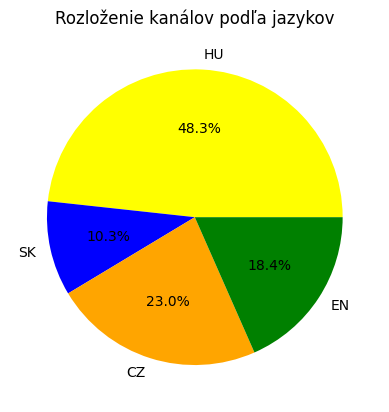


Kanály s filmami a hudbou:
                        Názov   Typ
2                         AMC  Film
5                          M+  Film
6                         TV4  Film
20                   Sorozat+  Film
32                 Prima Cool  Film
33                 Prima Love  Film
35               TV Barrandov  Film
39                     Film +  Film
41                  Film Café  Film
43                  Film + CZ  Film
50                       Cool  Film
51                 Film Mania  Film
65                 Super TV 2  Film
67                      Prime  Film
72              Filmbox Basic  Film
74  Paramount Channel Hungary  Film
75     Comedy Central Hungary  Film
85                        Wau  Film
86              Prima ZOOM HD  Film

Priemerný čas reklám za deň: 416.00 minút

Stĺpec D vyplnený


In [4]:
import openpyxl as xl
from openpyxl.styles import PatternFill, Font
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from config import get_data_file_path, get_output_file_path


path=get_data_file_path('Opakovanie na TEST.xlsx')
output_path=get_output_file_path('Opakovanie na TEST(vysledok).xlsx')


wb = xl.load_workbook(path)
print(wb.sheetnames)

def select_sheet(x):
    wb._active_sheet_index = x
    print("Active sheet: ", wb.active)
    sheet_obj = wb.active
    row = sheet_obj.max_row
    column = sheet_obj.max_column

    all_values = []
    for i in range(1, row + 1):
        row_values = []
        for j in range(1, column + 1):
            cell_obj = sheet_obj.cell(row=i, column=j)
            row_values.append(cell_obj.value)
        all_values.append(row_values)

    return all_values


data = select_sheet(0)

df = pd.DataFrame(data)

print(df)

hu = df[2].value_counts()['HU']
sk = df[2].value_counts()['SK']
cz = df[2].value_counts()['CZ']
en = df[2].value_counts()['EN']

print("HU: ", hu)
print("SK: ", sk)
print("CZ: ", cz)
print("EN: ", en)

y = np.array([hu, sk, cz, en])
mylabels = ["HU", "SK", "CZ", "EN"]
mycolors = ["yellow", "blue", "orange", "green"]

# Add percentages to the pie chart (autopct parameter)
plt.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%')
plt.title('Rozloženie kanálov podľa jazykov')
plt.show()




df_full = pd.read_excel(path)


print("\nKanály s filmami a hudbou:")
film_music = df_full[df_full['Typ'].str.contains('film|hudba', case=False, na=False)]
print(film_music[['Názov', 'Typ']])


df_full['Reklamy za deň'] = df_full['Reklamy          (minút za hodinu)'] * 24
avg_ads = df_full['Reklamy za deň'].mean()
print(f"\nPriemerný čas reklám za deň: {avg_ads:.2f} minút")


df_sorted = df_full.sort_values('Názov').reset_index(drop=True)
df_sorted['Poradie v TV'] = range(1, len(df_sorted) + 1)



df_sorted['Hodnotenie'] = df_sorted['Reklamy          (minút za hodinu)'].apply(
    lambda x: 'veľa' if x >= 15 else 'málo'
)


with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    df_sorted.to_excel(writer, sheet_name='Kanály', index=False)

    workbook = writer.book
    worksheet = writer.sheets['Kanály']


    green_fill = PatternFill(start_color='00FF00', end_color='00FF00', fill_type='solid')

    orange_fill = PatternFill(start_color='FFA500', end_color='FFA500', fill_type='solid')

    # Highlight rows with films and music
    for row in range(2, len(df_sorted) + 2):
        typ_value = worksheet.cell(row=row, column=5).value
        if typ_value and ('film' in str(typ_value).lower() or 'hudba' in str(typ_value).lower()):
            for col in range(1, 10):
                worksheet.cell(row=row, column=col).fill = green_fill

    # Add average to cell G89 with orange color
    worksheet.cell(row=89, column=7, value=avg_ads)
    worksheet.cell(row=89, column=7).fill = orange_fill
    worksheet.cell(row=89, column=7).font = Font(bold=True)
    worksheet.cell(row=89, column=6, value='PRIEMER:')
    worksheet.cell(row=89, column=6).font = Font(bold=True)

    # Adjust column widths
    worksheet.column_dimensions['B'].width = 30
    worksheet.column_dimensions['G'].width = 20
